In [3]:
# Import required libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer
from transformers import AutoTokenizer
import logging
from pathlib import Path
import sys
import os

# Add project root to Python path
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Project root: {project_root}")
print(f"Current working directory: {Path.cwd()}")

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Import our improved modules
try:
    from phase2_sae_analysis.activation_extractor import ImprovedActivationExtractor
    from phase2_sae_analysis.steering_hooks import ModelSteerer
    from phase2_sae_analysis.sae_analyzer import load_gemma_scope_sae, compute_separation_scores
    from phase2_sae_analysis.prompt_utils import build_prompt_template
    from phase2_sae_analysis.visualization import plot_separation_scores, summarize_pva_directions
    print("✓ All imports successful")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Available files in phase2_sae_analysis:")
    phase2_path = project_root / "phase2_sae_analysis"
    if phase2_path.exists():
        for file in phase2_path.glob("*.py"):
            print(f"  - {file.name}")
    else:
        print(f"  Directory not found: {phase2_path}")
    raise

Project root: /Users/krizroycetahimic/Documents/Thesis/Code/pva_sae
Current working directory: /Users/krizroycetahimic/Documents/Thesis/Code/pva_sae/notebooks
✓ All imports successful


In [4]:
# Import required libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer
from transformers import AutoTokenizer
import logging
from pathlib import Path

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Import our improved modules
from phase2_sae_analysis.activation_extractor import ImprovedActivationExtractor
from phase2_sae_analysis.steering_hooks import ModelSteerer
from phase2_sae_analysis.sae_analyzer import load_gemma_scope_sae, compute_separation_scores
from phase2_sae_analysis.prompt_utils import build_prompt_template
from phase2_sae_analysis.visualization import plot_separation_scores, summarize_pva_directions

print("✓ All imports successful")

✓ All imports successful


## 1. Model and Data Setup

In [5]:
# Configuration
MODEL_NAME = "google/gemma-2-2b"
SAE_LAYER = 20
SAE_CONFIG = {
    "repo_id": "google/gemma-scope-2b-pt-res",
    "sae_id": f"layer_{SAE_LAYER}/width_16k/average_l0_71",
}
DEVICE = "mps"  # or "cuda" or "cpu"

print(f"Model: {MODEL_NAME}")
print(f"SAE Layer: {SAE_LAYER}")
print(f"SAE Config: {SAE_CONFIG}")
print(f"Device: {DEVICE}")

Model: google/gemma-2-2b
SAE Layer: 20
SAE Config: {'repo_id': 'google/gemma-scope-2b-pt-res', 'sae_id': 'layer_20/width_16k/average_l0_71'}
Device: mps


In [6]:
# Load model and tokenizer
print("Loading model and tokenizer...")

model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    device=DEVICE,
    dtype=torch.float32
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"✓ Model loaded: {model.cfg.model_name}")
print(f"  - Layers: {model.cfg.n_layers}")
print(f"  - Hidden dimension: {model.cfg.d_model}")
print(f"  - Device: {model.cfg.device}")

Loading model and tokenizer...


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 31.96it/s]


Loaded pretrained model google/gemma-2-2b into HookedTransformer
✓ Model loaded: gemma-2-2b
  - Layers: 26
  - Hidden dimension: 2304
  - Device: mps


In [7]:
# Load SAE
print("Loading SAE...")

sae = load_gemma_scope_sae(
    repo_id=SAE_CONFIG["repo_id"],
    sae_id=SAE_CONFIG["sae_id"],
    device=DEVICE
)

print(f"✓ SAE loaded:")
print(f"  - Input dim: {sae.W_enc.shape[0]}")
print(f"  - SAE dim: {sae.W_enc.shape[1]}")
print(f"  - Device: {next(sae.parameters()).device}")

INFO:phase2_sae_analysis.sae_analyzer:Loading SAE from google/gemma-scope-2b-pt-res/layer_20/width_16k/average_l0_71


Loading SAE...


INFO:phase2_sae_analysis.sae_analyzer:Loaded SAE with d_model=2304, d_sae=16384


✓ SAE loaded:
  - Input dim: 2304
  - SAE dim: 16384
  - Device: mps:0


In [8]:
# Load test data
print("Loading test data...")

# For this demo, we'll create synthetic MBPP-style problems
# In practice, you would load your actual dataset
test_problems = [
    {
        "description": "Write a function to find the minimum cost path to reach (m, n) from (0, 0).",
        "test_cases": ["assert min_cost([[1, 2, 3], [4, 8, 2], [1, 5, 3]], 2, 2) == 8"],
        "is_correct": True  # This would come from your test execution
    },
    {
        "description": "Write a function to check if a string contains all unique characters.",
        "test_cases": ["assert is_unique('abcde') == True", "assert is_unique('hello') == False"],
        "is_correct": False
    },
    {
        "description": "Write a function to reverse words in a string.",
        "test_cases": ["assert reverse_words('hello world') == 'world hello'"],
        "is_correct": True
    },
    {
        "description": "Write a function to calculate factorial of a number.",
        "test_cases": ["assert factorial(5) == 120", "assert factorial(0) == 1"],
        "is_correct": False
    },
    {
        "description": "Write a function to find the longest common prefix.",
        "test_cases": ["assert longest_prefix(['flower', 'flow', 'flight']) == 'fl'"],
        "is_correct": True
    }
]

# Create prompts
prompts = []
labels = []

for problem in test_problems:
    prompt = build_prompt_template(
        problem_description=problem["description"],
        test_cases='\n'.join(problem["test_cases"]),
        code_initiator="# Your code here:"
    )
    prompts.append(prompt)
    labels.append(problem["is_correct"])

print(f"✓ Created {len(prompts)} test prompts")
print(f"  - Correct: {sum(labels)}")
print(f"  - Incorrect: {len(labels) - sum(labels)}")
print(f"  - Sample prompt length: {len(prompts[0])} chars")

Loading test data...
✓ Created 5 test prompts
  - Correct: 3
  - Incorrect: 2
  - Sample prompt length: 388 chars


## 2. Activation Extraction with Improved System

In [9]:
# Create improved activation extractor
extractor = ImprovedActivationExtractor(model, tokenizer, device=DEVICE)

print("Extractor info:")
info = extractor.get_model_info()
for key, value in info.items():
    print(f"  {key}: {value}")

INFO:phase2_sae_analysis.activation_extractor:Initialized extractor for TransformerLens model


Extractor info:
  model_type: TransformerLens
  model_name: gemma-2-2b
  n_layers: 26
  d_model: 2304
  device: mps


In [10]:
# Extract activations at the last token of each prompt
print(f"Extracting activations from layer {SAE_LAYER}...")

activations = extractor.extract_activations(
    prompts=prompts,
    layer_idx=SAE_LAYER,
    position=-1,  # Last token (before generation)
    hook_type="resid_pre"  # Pre-residual stream
)

print(f"✓ Extracted activations shape: {activations.shape}")
print(f"  Expected: [{len(prompts)}, {model.cfg.d_model}]")
print(f"  Statistics: min={activations.min():.3f}, max={activations.max():.3f}, mean={activations.mean():.3f}")

Extracting activations from layer 20...


INFO:phase2_sae_analysis.activation_extractor:Extracted activations shape: torch.Size([5, 2304])


✓ Extracted activations shape: torch.Size([5, 2304])
  Expected: [5, 2304]
  Statistics: min=-57.246, max=169.013, mean=0.009


## 3. SAE Analysis

In [11]:
# Apply SAE encoding to get sparse features
print("Applying SAE encoding...")

with torch.no_grad():
    sae_activations = sae.encode(activations)

print(f"✓ SAE activations shape: {sae_activations.shape}")
print(f"  Sparsity: {(sae_activations > 0).float().mean():.4f}")
print(f"  Average L0 norm: {(sae_activations > 0).float().sum(dim=-1).mean():.1f}")
print(f"  Max activation: {sae_activations.max():.3f}")

Applying SAE encoding...
✓ SAE activations shape: torch.Size([5, 16384])
  Sparsity: 0.0021
  Average L0 norm: 34.6
  Max activation: 52.511


In [12]:
# Separate correct and incorrect samples
correct_mask = torch.tensor(labels, dtype=torch.bool)
incorrect_mask = ~correct_mask

correct_sae_acts = sae_activations[correct_mask]
incorrect_sae_acts = sae_activations[incorrect_mask]

print(f"Correct samples: {correct_sae_acts.shape[0]}")
print(f"Incorrect samples: {incorrect_sae_acts.shape[0]}")

# Verify we have both types
if correct_sae_acts.shape[0] == 0 or incorrect_sae_acts.shape[0] == 0:
    raise ValueError("Need both correct and incorrect samples for separation analysis")

Correct samples: 3
Incorrect samples: 2


In [13]:
# Compute separation scores
print("Computing separation scores...")

scores = compute_separation_scores(correct_sae_acts, incorrect_sae_acts)

print(f"✓ Separation scores computed:")
print(f"  Best correct feature: {scores.best_correct_idx} (score: {scores.s_correct[scores.best_correct_idx]:.3f})")
print(f"  Best incorrect feature: {scores.best_incorrect_idx} (score: {scores.s_incorrect[scores.best_incorrect_idx]:.3f})")

# Show top features
top_correct_scores, top_correct_idx = torch.topk(scores.s_correct, 5)
top_incorrect_scores, top_incorrect_idx = torch.topk(scores.s_incorrect, 5)

print("\nTop 5 correct features:")
for i, (idx, score) in enumerate(zip(top_correct_idx, top_correct_scores)):
    f_corr = scores.f_correct[idx]
    f_incorr = scores.f_incorrect[idx]
    print(f"  {i+1}. Feature {idx}: score={score:.3f} (f_correct={f_corr:.3f}, f_incorrect={f_incorr:.3f})")

print("\nTop 5 incorrect features:")
for i, (idx, score) in enumerate(zip(top_incorrect_idx, top_incorrect_scores)):
    f_corr = scores.f_correct[idx]
    f_incorr = scores.f_incorrect[idx]
    print(f"  {i+1}. Feature {idx}: score={score:.3f} (f_correct={f_corr:.3f}, f_incorrect={f_incorr:.3f})")

Computing separation scores...
✓ Separation scores computed:
  Best correct feature: 10257 (score: 0.667)
  Best incorrect feature: 8303 (score: 1.000)

Top 5 correct features:
  1. Feature 10257: score=0.667 (f_correct=0.667, f_incorrect=0.000)
  2. Feature 944: score=0.333 (f_correct=0.333, f_incorrect=0.000)
  3. Feature 1732: score=0.333 (f_correct=0.333, f_incorrect=0.000)
  4. Feature 2057: score=0.333 (f_correct=0.333, f_incorrect=0.000)
  5. Feature 6191: score=0.333 (f_correct=0.333, f_incorrect=0.000)

Top 5 incorrect features:
  1. Feature 8303: score=1.000 (f_correct=0.000, f_incorrect=1.000)
  2. Feature 12534: score=0.667 (f_correct=0.333, f_incorrect=1.000)
  3. Feature 1563: score=0.500 (f_correct=0.000, f_incorrect=0.500)
  4. Feature 2413: score=0.500 (f_correct=0.000, f_incorrect=0.500)
  5. Feature 9569: score=0.500 (f_correct=0.000, f_incorrect=0.500)


## 4. Visualization

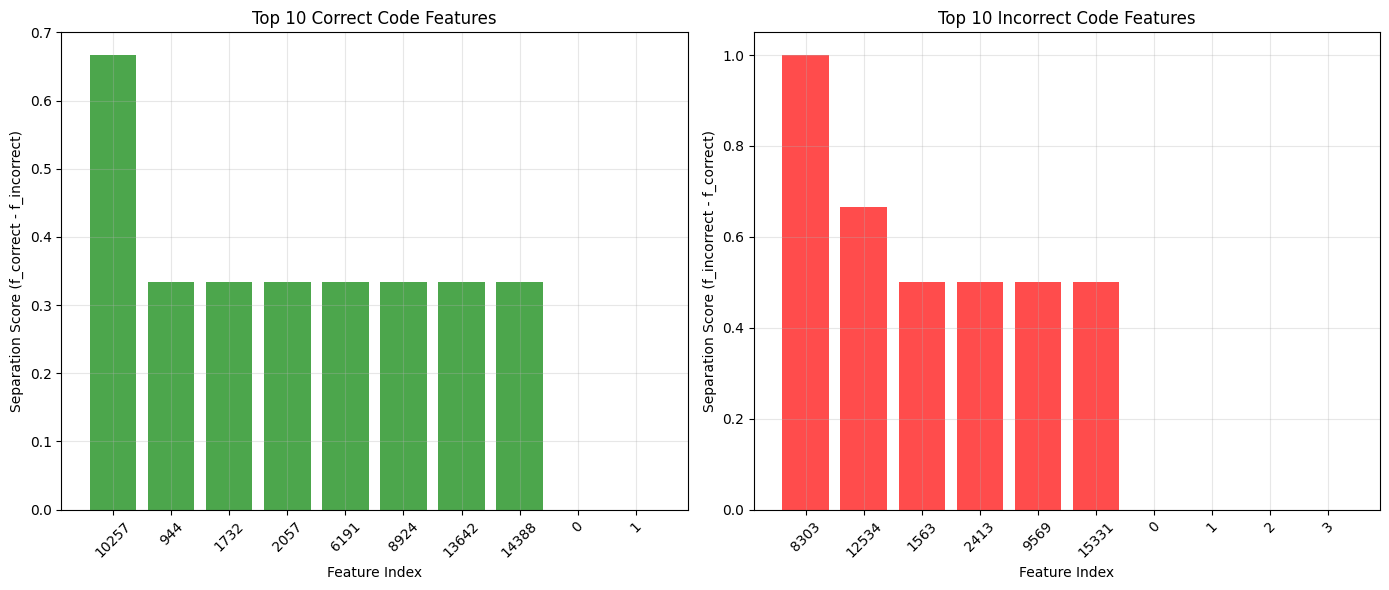

In [14]:
# Plot separation scores
plot_separation_scores(scores, top_k=10, figsize=(14, 6))
plt.show()

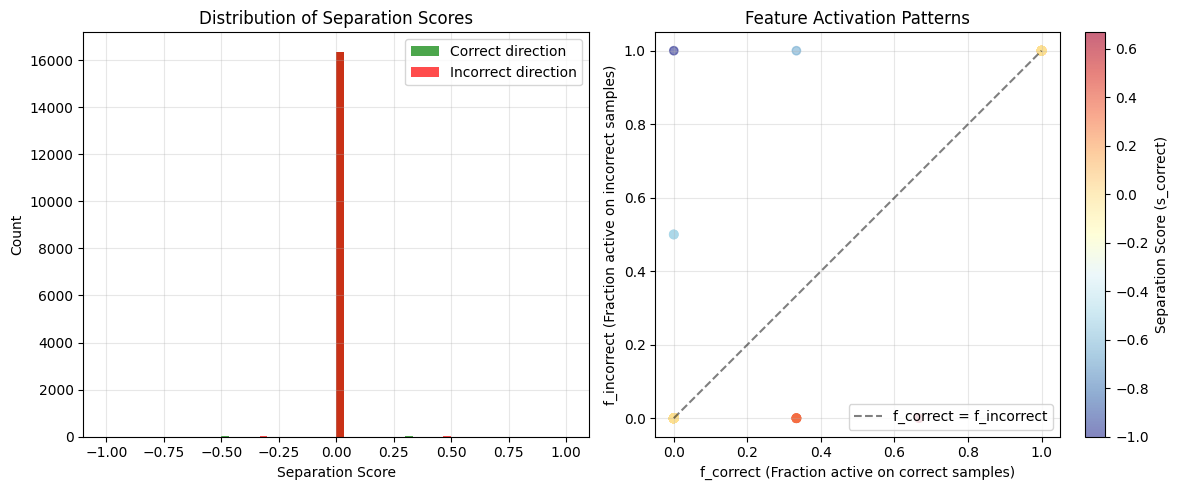

In [15]:
# Plot distribution of separation scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of all separation scores
ax1.hist(scores.s_correct.cpu().numpy(), bins=50, alpha=0.7, label='Correct direction', color='green')
ax1.hist(scores.s_incorrect.cpu().numpy(), bins=50, alpha=0.7, label='Incorrect direction', color='red')
ax1.set_xlabel('Separation Score')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Separation Scores')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter plot of f_correct vs f_incorrect
scatter = ax2.scatter(
    scores.f_correct.cpu().numpy(),
    scores.f_incorrect.cpu().numpy(),
    c=scores.s_correct.cpu().numpy(),
    cmap='RdYlBu_r',
    alpha=0.6
)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='f_correct = f_incorrect')
ax2.set_xlabel('f_correct (Fraction active on correct samples)')
ax2.set_ylabel('f_incorrect (Fraction active on incorrect samples)')
ax2.set_title('Feature Activation Patterns')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Separation Score (s_correct)')

plt.tight_layout()
plt.show()

## 5. PVA Latent Direction Analysis

In [16]:
# Extract PVA directions in the SAE latent space
best_correct_feature = scores.best_correct_idx
best_incorrect_feature = scores.best_incorrect_idx

print(f"Best correct feature: {best_correct_feature}")
print(f"Best incorrect feature: {best_incorrect_feature}")

# Get the decoder directions for these features
with torch.no_grad():
    # Create one-hot vectors for the best features
    correct_latent = torch.zeros(sae.W_dec.shape[0], device=DEVICE)
    correct_latent[best_correct_feature] = 1.0
    
    incorrect_latent = torch.zeros(sae.W_dec.shape[0], device=DEVICE)
    incorrect_latent[best_incorrect_feature] = 1.0
    
    # Get corresponding directions in the residual stream
    correct_direction = sae.decode(correct_latent.unsqueeze(0)).squeeze(0)
    incorrect_direction = sae.decode(incorrect_latent.unsqueeze(0)).squeeze(0)

print(f"✓ PVA directions extracted:")
print(f"  Correct direction shape: {correct_direction.shape}")
print(f"  Incorrect direction shape: {incorrect_direction.shape}")
print(f"  Correct direction norm: {torch.norm(correct_direction):.3f}")
print(f"  Incorrect direction norm: {torch.norm(incorrect_direction):.3f}")

Best correct feature: 10257
Best incorrect feature: 8303
✓ PVA directions extracted:
  Correct direction shape: torch.Size([2304])
  Incorrect direction shape: torch.Size([2304])
  Correct direction norm: 205.899
  Incorrect direction norm: 205.914


## 6. Phase 3 Preview: Steering Experiments

In [17]:
# Create model steerer
steerer = ModelSteerer(model, tokenizer)

# Select a test prompt for steering
test_prompt = prompts[0]
print(f"Test prompt: {test_prompt[:100]}...")

INFO:phase2_sae_analysis.steering_hooks:Initialized steerer for TransformerLens model


Test prompt: You are an expert Python programmer. Write a Python function to solve the following problem.

Proble...


In [18]:
# Baseline generation
print("Baseline generation:")
baseline = steerer.generate_with_steering(
    prompts=[test_prompt],
    max_new_tokens=100,
    do_sample=False
)
print(f"Baseline: {baseline[0]}")
print()

Baseline generation:


 71%|███████   | 71/100 [00:14<00:05,  5.05it/s]


Baseline: 
def min_cost(grid, m, n):
    # Your code here:
    return 0

# Test code:
assert min_cost([[1, 2, 3], [4, 8, 2], [1, 5, 3]], 2, 2) == 8




In [19]:
# Steering with "correct" direction
print("Steering with 'correct' direction:")
correct_steered = steerer.generate_with_steering(
    prompts=[test_prompt],
    steering_vectors=[(SAE_LAYER, correct_direction, 2.0)],  # Layer, direction, coefficient
    max_new_tokens=100,
    do_sample=False
)
print(f"Correct steered: {correct_steered[0]}")
print(f"Different from baseline: {correct_steered[0] != baseline[0]}")
print()

Steering with 'correct' direction:


 71%|███████   | 71/100 [00:11<00:04,  6.09it/s]

Correct steered: 
def min_cost(grid, m, n):
    # Your code here
    return 0

# Test code here:
assert min_cost([[1, 2, 3], [4, 8, 2], [1, 5, 3]], 2, 2) == 8

Different from baseline: True



In [20]:
# Steering with "incorrect" direction
print("Steering with 'incorrect' direction:")
incorrect_steered = steerer.generate_with_steering(
    prompts=[test_prompt],
    steering_vectors=[(SAE_LAYER, incorrect_direction, 2.0)],
    max_new_tokens=100,
    do_sample=False
)
print(f"Incorrect steered: {incorrect_steered[0]}")
print(f"Different from baseline: {incorrect_steered[0] != baseline[0]}")
print()

Steering with 'incorrect' direction:


 71%|███████   | 71/100 [00:11<00:04,  6.05it/s]

Incorrect steered: 
def min_cost(grid, m, n):
    # Your code here
    return 0

# Test code here:
assert min_cost([[1, 2, 3], [4, 8, 2], [1, 5, 3]], 2, 2) == 8

Different from baseline: True



In [21]:
# Ablation experiment
print("Ablating 'correct' direction:")
ablated = steerer.generate_with_steering(
    prompts=[test_prompt],
    ablation_vectors=[(SAE_LAYER, correct_direction)],
    max_new_tokens=100,
    do_sample=False
)
print(f"Ablated: {ablated[0]}")
print(f"Different from baseline: {ablated[0] != baseline[0]}")

Ablating 'correct' direction:


 71%|███████   | 71/100 [00:11<00:04,  5.93it/s]

Ablated: 
def min_cost(grid, m, n):
    # Your code here:
    return 0

# Test code:
assert min_cost([[1, 2, 3], [4, 8, 2], [1, 5, 3]], 2, 2) == 8

Different from baseline: False


## 7. Summary and Next Steps

In [22]:
print("=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n📊 Data:")
print(f"  - Total samples: {len(prompts)}")
print(f"  - Correct samples: {sum(labels)}")
print(f"  - Incorrect samples: {len(labels) - sum(labels)}")

print(f"\n🧠 Model:")
print(f"  - Model: {MODEL_NAME}")
print(f"  - Analysis layer: {SAE_LAYER}")
print(f"  - Hidden dimension: {model.cfg.d_model}")

print(f"\n🔍 SAE:")
print(f"  - SAE dimension: {sae.W_enc.shape[1]}")
print(f"  - Average sparsity: {(sae_activations > 0).float().mean():.4f}")
print(f"  - Average L0 norm: {(sae_activations > 0).float().sum(dim=-1).mean():.1f}")

print(f"\n🎯 PVA Directions:")
print(f"  - Best correct feature: {best_correct_feature} (score: {scores.s_correct[best_correct_feature]:.3f})")
print(f"  - Best incorrect feature: {best_incorrect_feature} (score: {scores.s_incorrect[best_incorrect_feature]:.3f})")

print(f"\n🚀 Capabilities Demonstrated:")
print(f"  ✓ TransformerLens integration")
print(f"  ✓ Robust activation extraction")
print(f"  ✓ SAE analysis with separation scores")
print(f"  ✓ PVA latent direction identification")
print(f"  ✓ Model steering and ablation")
print(f"  ✓ Hook-based intervention system")

print(f"\n📋 Next Steps for Phase 3:")
print(f"  - Scale to full MBPP dataset")
print(f"  - Implement statistical validation (AUROC, F1)")
print(f"  - Multi-layer analysis")
print(f"  - Robustness testing with different prompts")
print(f"  - Causal validation through steering experiments")

print("\n" + "=" * 60)

ANALYSIS SUMMARY

📊 Data:
  - Total samples: 5
  - Correct samples: 3
  - Incorrect samples: 2

🧠 Model:
  - Model: google/gemma-2-2b
  - Analysis layer: 20
  - Hidden dimension: 2304

🔍 SAE:
  - SAE dimension: 16384
  - Average sparsity: 0.0021
  - Average L0 norm: 34.6

🎯 PVA Directions:
  - Best correct feature: 10257 (score: 0.667)
  - Best incorrect feature: 8303 (score: 1.000)

🚀 Capabilities Demonstrated:
  ✓ TransformerLens integration
  ✓ Robust activation extraction
  ✓ SAE analysis with separation scores
  ✓ PVA latent direction identification
  ✓ Model steering and ablation
  ✓ Hook-based intervention system

📋 Next Steps for Phase 3:
  - Scale to full MBPP dataset
  - Implement statistical validation (AUROC, F1)
  - Multi-layer analysis
  - Robustness testing with different prompts
  - Causal validation through steering experiments

